In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as trans
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler
%matplotlib inline

In [3]:
trainset = dsets.MNIST(root='../data/mnist',train=True,download=True,transform=trans.ToTensor())
testset = dsets.MNIST(root='../data/mnist',train=False,download=True,transform=trans.ToTensor())

Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
train_loader = DataLoader(trainset,batch_size=64,shuffle=True,num_workers=4)
test_loader = DataLoader(testset,batch_size=64,shuffle=False,num_workers=4)

In [0]:
Num_Classes = 10
input_dim = 28*28
nsamples = 60000
nepoch = 30
lr = 1e-2

W = torch.rand((input_dim,Num_Classes),requires_grad=True)
b = torch.zeros((1,Num_Classes),requires_grad=True)

optimizer = torch.optim.Adam([W,b],lr=lr)

scheduler = lr_scheduler.MultiStepLR(optimizer=optimizer,milestones=[10,15,25])


In [0]:
def cost(x,y):        # 损失函数
  pred = x.matmul(W)+b
  return (pred-y).pow(2).mean()


def to_one_hot(X,y):     # 转化为one-hot变量
  n = X.size(0)
  onehot_X = X.view(n,input_dim)
  onehot_y = torch.zeros((n,Num_Classes))
  onehot_y.scatter_(1,y.view(-1,1),1)
  return onehot_X,onehot_y

In [0]:
def train_epoch(train_set,optimizer):  # 模型训练器，一个epoch，返回平均错误率
  error_total = 0
  for bx,by in train_set:
    x,y = to_one_hot(bx,by)
    optimizer.zero_grad()
    error = cost(x,y)
    error.backward()
    optimizer.step()
    error_total += error.item()

  return error_total/len(train_set)

In [8]:
for epoch in range(nepoch): # 训练模型
  scheduler.step()
  current_lr = scheduler.get_lr()[0]
  error = train_epoch(train_loader,optimizer)
  print("%d:current_lr=%.5f,error=%.5f"%(epoch,current_lr,error))
  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


0:current_lr=0.01000,error=58.17510
1:current_lr=0.01000,error=0.44176
2:current_lr=0.01000,error=0.23976
3:current_lr=0.01000,error=0.14804
4:current_lr=0.01000,error=0.09595
5:current_lr=0.01000,error=0.06668
6:current_lr=0.01000,error=0.05269
7:current_lr=0.01000,error=0.04776
8:current_lr=0.01000,error=0.04907
9:current_lr=0.00010,error=0.04008
10:current_lr=0.00100,error=0.03975
11:current_lr=0.00100,error=0.03997
12:current_lr=0.00100,error=0.04019
13:current_lr=0.00100,error=0.04015
14:current_lr=0.00001,error=0.03849
15:current_lr=0.00010,error=0.03837
16:current_lr=0.00010,error=0.03834
17:current_lr=0.00010,error=0.03834
18:current_lr=0.00010,error=0.03834
19:current_lr=0.00010,error=0.03833
20:current_lr=0.00010,error=0.03833
21:current_lr=0.00010,error=0.03833
22:current_lr=0.00010,error=0.03833
23:current_lr=0.00010,error=0.03832
24:current_lr=0.00000,error=0.03812
25:current_lr=0.00001,error=0.03809
26:current_lr=0.00001,error=0.03808
27:current_lr=0.00001,error=0.03808
2

In [0]:
def pred(x): # 模型预测，返回标签，dim=batch*1
  pred_y = x.matmul(W)+b
  _,label = pred_y.max(dim=1)
  return label
  

In [0]:
def evaluate(data_loader): # 模型评估，返回在训练集上的准确率
  correct = 0
  total = 0
  for bx,by in data_loader:
    x,y = to_one_hot(bx,by)
    pred_lable = pred(x)
    correct += (pred_lable.data==by).float().sum()
    total += y.size(0)

  return correct/total


In [12]:
ans = evaluate(test_loader)
print(ans)

tensor(0.8588)


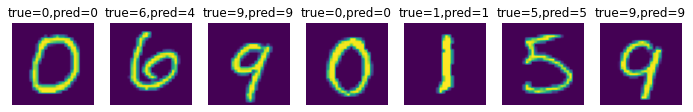

In [13]:
for X,y in test_loader:
  break;
X = X.view(-1,784)
pred_y = pred(X)
plt.figure(figsize=(12,5))
for i in range(7):
  plt.subplot(1,7,(i+1))
  img = X[10+i].squeeze().view(28,28).numpy()
  plt.imshow(img)
  plt.title("true=%d,pred=%d"%(y[10+i],pred_y[10+i]))
  plt.axis('off')